In [1]:
import numpy as np
import pandas as pd

import sklearn as sk
import matplotlib.pyplot as plt
from obspy import Stream, Trace, UTCDateTime
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import pylab as pl
from keras.callbacks import ModelCheckpoint

import keras

from keras.layers import Activation, Conv1D, Dense, Dropout, Flatten, MaxPooling3D, BatchNormalization, InputLayer, LSTM
from keras.layers import Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.utils import Sequence
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import ParameterGrid
import re
from sklearn.metrics import confusion_matrix

import os
import sys
classes_dir = 'F:\Thesis_ssd\MasterThesis3.0'
os.chdir(classes_dir)
from Classes.DataProcessing.LoadData import LoadData
from Classes.DataProcessing.HelperFunctions import HelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
from Classes.DataProcessing.DataGenerator import DataGenerator
from Classes.DataProcessing.NoiseAugmentor import NoiseAugmentor
from Classes.DataProcessing.TimeAugmentor import TimeAugmentor
from Classes.Modeling.Models import Models
from Classes.Modeling.CustomCallback import CustomCallback
from Classes.Scaling.ScalerFitter import ScalerFitter
from Classes.Scaling.MinMaxScalerFitter import MinMaxScalerFitter
from Classes.Scaling.StandardScalerFitter import StandardScalerFitter
from Classes import Tf_shutup
Tf_shutup.Tf_shutup()

from livelossplot import PlotLossesKeras

import tensorflow as tf

from matplotlib.colors import ListedColormap
%matplotlib inline
plt.rcParams["figure.figsize"]= (15,15)
helper = HelperFunctions()

import sys
ISCOLAB = 'google.colab' in sys.modules

import random
import pprint

base_dir = 'F:\Thesis_ssd\MasterThesis3.0'
os.chdir(base_dir)

In [2]:
### Data conditions: ###
load_args = {
    'earth_explo_only' : False,
    'noise_earth_only' : True,
    'downsample' : True,
    'upsample' : True,
    'frac_diff' : 0.5,
    'seed' : 1,
    'subsample_size' : 0.6
}

loadData = LoadData(**load_args)

full_ds, train_ds, val_ds, test_ds = loadData.get_datasets()
noise_ds = loadData.noise_ds
handler = DataHandler(loadData)
dataGen = DataGenerator(loadData)

if load_args['earth_explo_only']:
    full_and_noise_ds = np.concatenate((full_ds, noise_ds))
    timeAug = TimeAugmentor(handler, full_and_noise_ds, seed = load_args['seed'])
else:
    timeAug = TimeAugmentor(handler, full_ds, seed = load_args['seed'])

In [3]:
print(len(train_ds), len(val_ds), len(test_ds))
classes, counts = handler.get_class_distribution_from_ds(full_ds)
print("Nr noise samples " + str(len(loadData.noise_ds)))

63379 5592 5593
Total: 74564, earthquake: 37282, noise: 37282
Nr noise samples 31711


In [4]:
noise_ds.shape

(31711, 3)

In [5]:
############ Model picker #############
model_nr = 7
num_classes = len(classes)

########### Hyperparameters ###########
batch_size = 64
epochs = 80
learning_rate = 0.001
#opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, clipnorm=1.0, clipvalue=0.5)
opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
activation = 'tanh'
output_layer_activation = 'softmax'
dropout_rate = 0
filters = 13
kernel_size = 5
l1_r = 0.0001
l2_r = 0.01
padding = 'same'
start_neurons = 32

########### Preprocessing ###########
use_noise_augmentor = False
use_time_augmentor = True
detrend = False
use_scaler = True
use_highpass = False
highpass_freq = 0.2

use_tensorboard = False
use_livelossplot = True
use_custom = False

In [6]:
def clear_tensorboard_dir():
    import os
    import shutil
    path = f"{base_dir}/Tensorboard_dir/fit"
    files = os.listdir(path)
    print(files)
    for f in files:
        shutil.rmtree(os.path.join(path,f))
        
if use_tensorboard:
    import datetime
    clear_tensorboard_dir()
    %load_ext tensorboard
    %tensorboard --logdir tensorboard_dir/fit
    log_dir = f"{base_dir}/tensorboard_dir/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    callbacks = [tensorboard_callback]

if use_custom:
    custom_callback = CustomCallback(data_gen)
    callbacks = custom_callback
elif use_livelossplot:
    callbacks = PlotLossesKeras()

In [7]:
num_ds, channels, timesteps = dataGen.get_trace_shape_no_cast(train_ds, use_time_augmentor)
input_shape = (batch_size, channels, timesteps)

build_model_args = {'model_nr' : model_nr,
                    'input_shape' : input_shape,
                    'num_classes' : num_classes,
                    'dropout_rate' : dropout_rate,
                    'activation' : activation,
                    'output_layer_activation' : output_layer_activation,
                    'l2_r' : l2_r,
                    'l1_r' : l1_r,
                    'full_regularizer' : True,
                    'start_neurons' : start_neurons,
                    'filters' : filters,
                    'kernel_size' : kernel_size,
                    'padding' : 'same'}
model = Models(**build_model_args).model

model_args = {'loss' : "binary_crossentropy",
              'optimizer' : opt,
              'metrics' : ["accuracy","MSE",
                           tf.keras.metrics.Precision(thresholds=None, top_k=None, class_id=None, name=None, dtype=None),
                           tf.keras.metrics.Recall(thresholds=None, top_k=None, class_id=None, name=None, dtype=None)]}
model.compile(**model_args)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (64, 3, 32)               772224    
_________________________________________________________________
dropout (Dropout)            (64, 3, 32)               0         
_________________________________________________________________
batch_normalization (BatchNo (64, 3, 32)               128       
_________________________________________________________________
lstm_1 (LSTM)                (64, 16)                  3136      
_________________________________________________________________
dropout_1 (Dropout)          (64, 16)                  0         
_________________________________________________________________
batch_normalization_1 (Batch (64, 16)                  64        
_________________________________________________________________
flatten (Flatten)            (64, 16)                  0

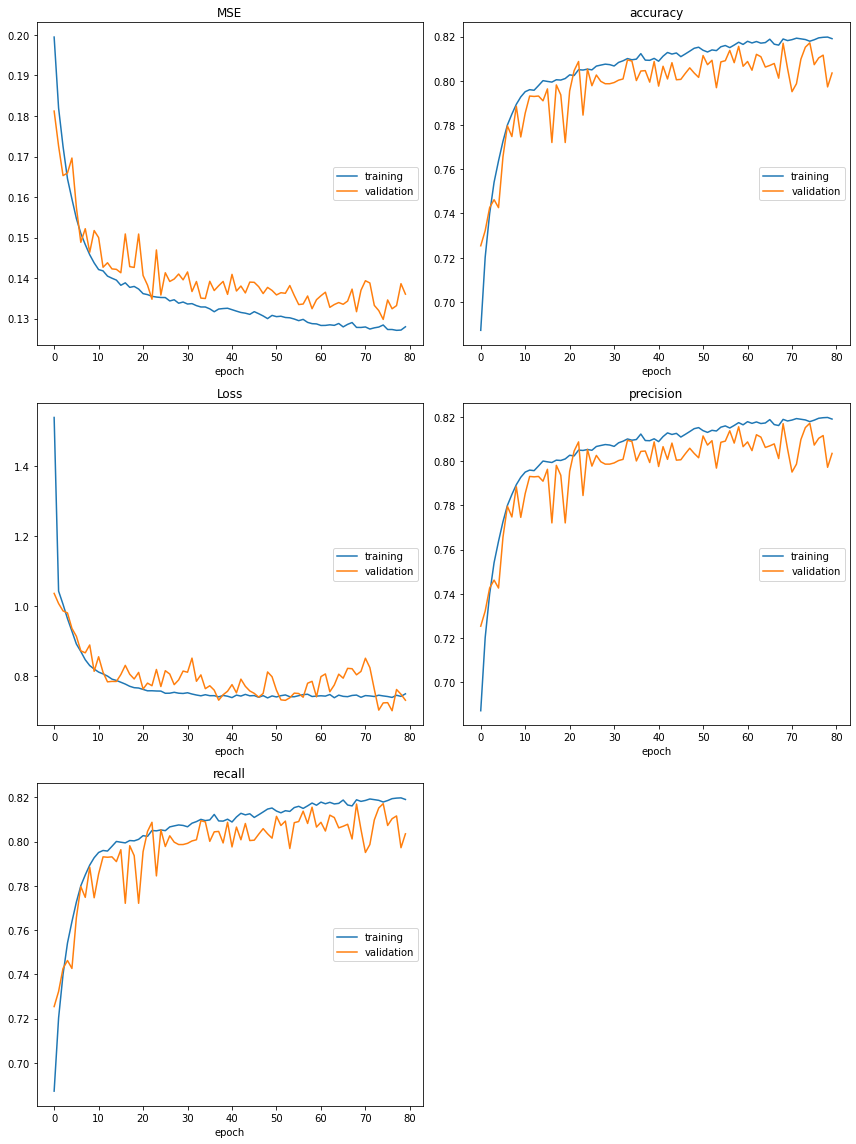

MSE
	training         	 (min:    0.127, max:    0.199, cur:    0.128)
	validation       	 (min:    0.130, max:    0.181, cur:    0.136)
accuracy
	training         	 (min:    0.687, max:    0.820, cur:    0.819)
	validation       	 (min:    0.725, max:    0.817, cur:    0.804)
Loss
	training         	 (min:    0.738, max:    1.538, cur:    0.750)
	validation       	 (min:    0.702, max:    1.036, cur:    0.732)
precision
	training         	 (min:    0.687, max:    0.820, cur:    0.819)
	validation       	 (min:    0.725, max:    0.817, cur:    0.804)
recall
	training         	 (min:    0.687, max:    0.820, cur:    0.819)
	validation       	 (min:    0.725, max:    0.817, cur:    0.804)
990/990 [==============================] - 135s 136ms/step - loss: 0.7498 - accuracy: 0.8190 - MSE: 0.1280 - precision: 0.8190 - recall: 0.8190 - val_loss: 0.7315 - val_accuracy: 0.8035 - val_MSE: 0.1360 - val_precision: 0.8035 - val_recall: 0.8035


In [8]:
scaler = None
noiseAug = None
if use_time_augmentor:
    timeAug.fit()
if use_scaler:
    scaler = StandardScalerFitter(train_ds, timeAug).fit_scaler(detrend = detrend)
if use_noise_augmentor:
    noiseAug = NoiseAugmentor(train_ds, use_scaler, scaler, loadData)

    
    

gen_args = {
    'batch_size' : batch_size,
    'detrend' : detrend,
    'num_classes' : num_classes,
    'use_scaler' : use_scaler,
    'scaler' : scaler,
    'use_time_augmentor' : use_time_augmentor,
    'timeAug' : timeAug,
    'use_noise_augmentor' : use_noise_augmentor,
    'augmentor' : noiseAug,
    'use_highpass' : use_highpass,
    'highpass_freq' : highpass_freq
}


train_gen = dataGen.data_generator(train_ds, **gen_args)
val_gen = dataGen.data_generator(val_ds, **gen_args)
test_gen = dataGen.data_generator(test_ds, **gen_args)



args = {'steps_per_epoch' : helper.get_steps_per_epoch(train_ds, batch_size),
        'epochs' : epochs,
        'validation_data' : val_gen,
        'validation_steps' : helper.get_steps_per_epoch(val_ds, batch_size),
        'verbose' : 1,
        'use_multiprocessing' : False, 
        'workers' : 1,
        'callbacks' : [callbacks]
}

model_fit = model.fit(train_gen, **args)

Instructions for updating:
Please use Model.evaluate, which supports generators.
88/87 [==============================] - 11s 126ms/step - loss: 0.7505 - accuracy: 0.8002 - MSE: 0.1414 - precision: 0.8002 - recall: 0.8002
[0.7505416870117188, 0.8002485632896423, 0.14137792587280273, 0.8002485632896423, 0.8002485632896423]
Instructions for updating:
Please use Model.predict, which supports generators.
[[1054 1710]
 [1111 1718]]


F:\Thesis_ssd\MasterThesis3.0\Classes\DataProcessing\HelperFunctions.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
F:\Thesis_ssd\MasterThesis3.0\Classes\DataProcessing\HelperFunctions.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


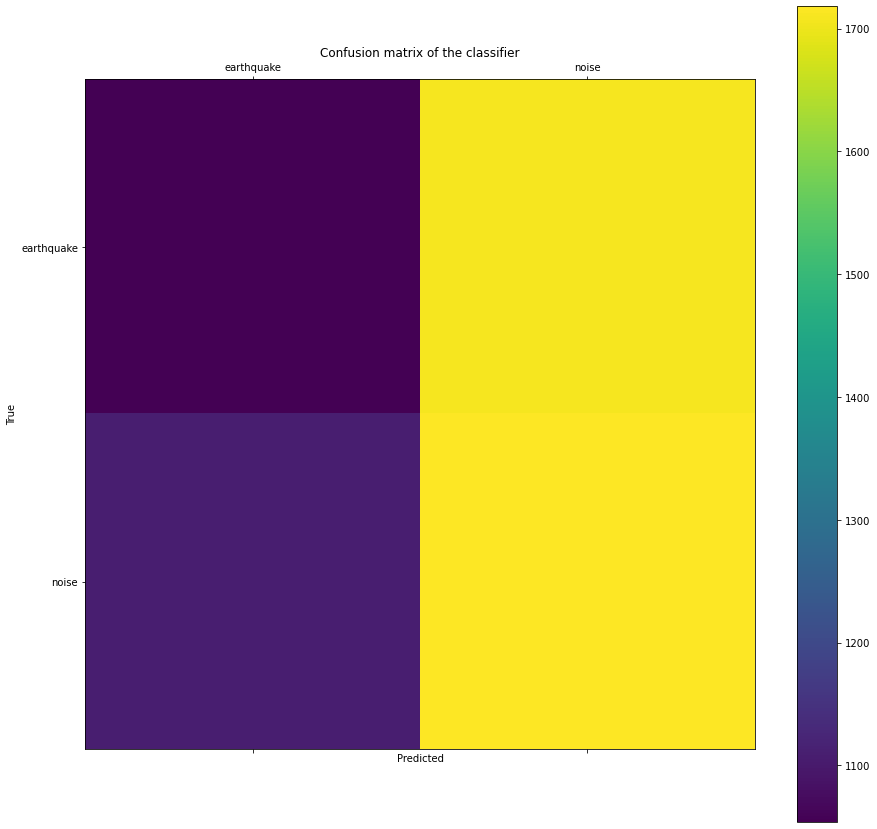

In [9]:
helper.evaluate_model(model, test_gen, test_ds, batch_size, handler.label_dict)

In [10]:
X.shape

NameError: name 'X' is not defined